#### Import required layers and utils from the framework

In [3]:
import keras

from keras.utils import np_utils

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, merge, Input
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D, UpSampling2D, ZeroPadding2D

#### Import other required utils

In [6]:
import dicom
import fnmatch
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy.misc.pilutil import imresize

/home/intern/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/intern/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Constants and pathes

In [ ]:
BATCH_SIZE = 5
CLASSES_NUM = 10
EPOCH_NUM = 100
X_IMAGE_SIZE = 572
TRAIN_DIR = '/home/intern/data/rib_detection/train'
TEST_DIR = '/home/intern/data/rib_detection/validate'

#### Model construction. It recaps the U-net structure.

In [89]:
main_input = Input(shape=(1, X_IMAGE_SIZE, X_IMAGE_SIZE))
input_shape = (-1, 1, X_IMAGE_SIZE, X_IMAGE_SIZE)

convolution_1_1 = Convolution2D(8, 3, 3, input_shape=input_shape, activation='relu')(main_input)
convolution_1_2 = Convolution2D(8, 3, 3, activation='relu')(convolution_1_1)
pool_1 = MaxPooling2D(pool_size=(2, 2))(convolution_1_2)

convolution_2_1 = Convolution2D(16, 3, 3, activation='relu')(pool_1)
convolution_2_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_2_1)
pool_2 = MaxPooling2D(pool_size=(2, 2))(convolution_2_2)

convolution_3_1 = Convolution2D(32, 3, 3, activation='relu')(pool_2)
convolution_3_2 = Convolution2D(32, 3, 3, activation='relu')(convolution_3_1)
pool_3 = MaxPooling2D(pool_size=(2, 2))(convolution_3_2)

convolution_4_1 = Convolution2D(64, 3, 3, activation='relu')(pool_3)
convolution_4_2 = Convolution2D(64, 3, 3, activation='relu')(convolution_4_1)
pool_4 = MaxPooling2D(pool_size=(2, 2))(convolution_4_2)

convolution_5_1 = Convolution2D(128, 3, 3, activation='relu')(pool_4)
convolution_5_2 = Convolution2D(128, 3, 3, activation='relu')(convolution_5_1)

first_upsampled = UpSampling2D(size=(2, 2))(convolution_5_2)
# second_cropped = ZeroPadding2D((-4, -4))(convolution_4_2)
# first_merged = merge([first_upsampled, second_cropped], mode='concat', concat_axis=1)
convolution_6_1 = Convolution2D(64, 3, 3, activation='relu')(first_upsampled)
convolution_6_2 = Convolution2D(64, 3, 3, activation='relu')(convolution_6_1)

second_upsampled = UpSampling2D(size=(2, 2))(convolution_6_2)
# first_cropped = ZeroPadding2D((-18, -18))(convolition_1_3)
# second_merged = merge([second_upsampled, first_cropped], mode='concat', concat_axis=1)
convolution_7_1 = Convolution2D(32, 3, 3, activation='relu')(second_upsampled)
convolution_7_2 = Convolution2D(32, 3, 3, activation='relu')(convolution_7_1)

third_upsampled = UpSampling2D(size=(2, 2))(convolution_7_2)
convolution_8_1 = Convolution2D(16, 3, 3, activation='relu')(third_upsampled)
convolution_8_2 = Convolution2D(16, 3, 3, activation='relu')(convolution_8_1)

fourth_upsampled = UpSampling2D(size=(2, 2))(convolution_8_2)
convolution_9_1 = Convolution2D(8, 3, 3, activation='relu')(fourth_upsampled)
convolution_9_2 = Convolution2D(8, 3, 3, activation='relu')(convolution_9_1)

convolution_10_1 = Convolution2D(1, 1, 1, activation='sigmoid')(convolution_9_2)

#### Model compilation

In [85]:
model = Model(input=main_input, output=convolution_10_1)
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

# for layer in model.layers:
#     print(layer)
# print(model.layers[7].output_shape)
# print(model.layers[11].output_shape)
print(model.layers[-1].output_shape)

(None, 1, 388, 388)


#### Data loading and preprocessing. 
We resize input images to squares of size X_IMAGE_SIZE and output images to Y_IMAGE_SIZE. It is required because the U-net architecture implies reduction of size

In [ ]:
Y_IMAGE_SIZE = model.layers[-1].output_shape[2]

X_train = []
Y_train = []
X_test = []
Y_test = []

for directory, x_arr, y_arr in zip([TRAIN_DIR, TEST_DIR], [X_train, X_test], [Y_train, Y_test]):
    dcm_images = sorted([os.path.join(path, f)
                                     for path, _, files in os.walk(directory)
                                     for f in fnmatch.filter(files, 'image*.dcm')])

    dcm_labels = sorted([os.path.join(path, f)
                         for path, _, files in os.walk(directory)
                         for f in fnmatch.filter(files, 'ribsMask*.dcm')])

    for img, lbl in zip(dcm_images, dcm_labels):
        x_arr.append(imresize(dicom.read_file(img).pixel_array, [X_IMAGE_SIZE, X_IMAGE_SIZE]))
        y_arr.append(imresize(dicom.read_file(lbl).pixel_array, [Y_IMAGE_SIZE, Y_IMAGE_SIZE]))
        
X_train  = np.expand_dims(np.array(X_train, dtype=np.float32), 1) / 255
Y_train  = np.expand_dims(np.array(Y_train, dtype=np.float32), 1) / 255

X_test  = np.expand_dims(np.array(X_test, dtype=np.float32), 1) / 255
Y_test  = np.expand_dims(np.array(Y_test, dtype=np.float32), 1) / 255

print('X_train shape: %s' % (X_train.shape, ))
print('y_train shape: %s' % (Y_train.shape, ))
print('X_test shape: %s' % (X_test.shape, ))
print('y_test shape: %s' % (Y_test.shape, ))

In [72]:
hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCH_NUM,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score)

INFO (theano.gof.compilelock): Refreshing lock /home/intern/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.1-64/lock_dir/lock


Train on 30 samples, validate on 10 samples
Epoch 1/100
30/30 [==============================] - 27s - loss: 0.6575 - val_loss: 0.6200
Epoch 2/100
30/30 [==============================] - 26s - loss: 0.6605 - val_loss: 0.6078
Epoch 3/100
30/30 [==============================] - 27s - loss: 0.6103 - val_loss: 0.5695
Epoch 4/100
30/30 [==============================] - 29s - loss: 0.5126 - val_loss: 0.4697
Epoch 5/100
30/30 [==============================] - 25s - loss: 0.4970 - val_loss: 0.6116
Epoch 6/100
30/30 [==============================] - 25s - loss: 0.5280 - val_loss: 0.4954
Epoch 7/100
30/30 [==============================] - 24s - loss: 0.4827 - val_loss: 0.5238
Epoch 8/100
30/30 [==============================] - 24s - loss: 0.5305 - val_loss: 0.5496
Epoch 9/100
30/30 [==============================] - 24s - loss: 0.4883 - val_loss: 0.4375
Epoch 10/100
30/30 [==============================] - 24s - loss: 0.4668 - val_loss: 0.4190
Epoch 11/100
30/30 [=========================

model

0.361624419689


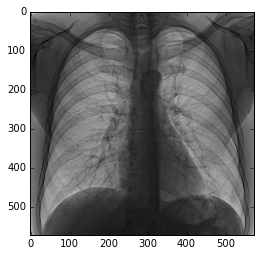

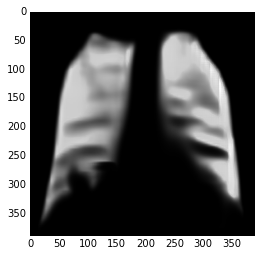

In [78]:
%matplotlib inline
print(score)
plt.set_cmap('gray')
plt.figure()
plt.imshow(X_train[0][0])
plt.figure()
plt.imshow(model.predict(np.expand_dims(X_train[3], 0))[0][0])
# plt.imshow(X_train[0].transpose([1, 2, 0]))
# print(y_train[0])

(1, 8, 28, 28)


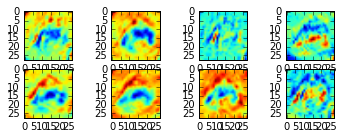

In [89]:
from keras import backend as K

# with a Sequential model
get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
layer_output = get_layer_output([np.expand_dims(X_train[0], axis=0)])[0]
print(layer_output.shape)

for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(layer_output[0][i])